# Final Project - CIS*4780 - Computational Intelligence
### Students names: Arnab Sagar & Nicholas Baker
### Students ids: 1088717 & 1100494
### Students userids: arnab & nbaker05
### Date: 2023/12/08

If you want to run this is the best environment click this link
https://drive.google.com/drive/folders/1cHoh9MnAOcQs6RFvhu0CFEj_wRYLAVq1?usp=sharing

This will share the folder with all the nessicary information. As well as another version of the code that can be run easily in this environment.

### Starting Code with Functions

In [1]:
import torch
import torch.nn as nn
import torchvision
import os
import re
import numpy as np
import time
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

resnet_time = 0
vgg_time = 0
inception_time = 0

In [2]:
# If running locally comment this cell out
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# If running locally change this directory to the current directory it is running in
PATH_TO_PROJECT = "/content/drive/MyDrive/cis4780_final"
%ls {PATH_TO_PROJECT}
# If running locally change this to the location that the dataset is located
PATH_TO_DATASET = os.path.join(PATH_TO_PROJECT, "mri_dataset")

ls: cannot access '/content/drive/MyDrive/cis4780_final': No such file or directory


In [4]:
def make_graph(train_acc, train_loss, val_acc, val_loss, num_epochs, model_name):
  # Create subplots
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

  # Plot on the first subplot
  axes[0].plot(range(1,num_epochs+1), train_acc, label='Training Accuracy', marker='o')
  axes[0].plot(range(1,num_epochs+1), val_acc, label='Validation Accuracy', marker='o')
  axes[0].legend()
  axes[0].set_xlabel('Number of Epochs')
  axes[0].set_ylabel('Accuracy')
  axes[0].grid()

  # Plot on the second subplot
  axes[1].plot(range(1,num_epochs+1), train_loss, label='Training loss', marker='o')
  axes[1].plot(range(1,num_epochs+1), val_loss, label='Validation loss', marker='o')
  axes[1].legend()
  axes[1].set_xlabel('Number of Epochs')
  axes[1].set_ylabel('Loss')
  axes[1].grid()

  axes[0].set_title(f'{model_name} Accuracy')
  axes[1].set_title(f'{model_name} Loss')

  # Adjust layout to prevent clipping of titles
  plt.tight_layout()

  # Show the plots
  plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, model_name, num_epochs=25):

    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            inference = time.time()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    if model_name == "Inception-V3":
                      logits = outputs.logits if hasattr(outputs, 'logits') else outputs  # Handle potential attribute difference
                      _, preds = torch.max(logits, 1)
                      loss = criterion(logits, labels)
                    else:
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_acc.append(epoch_acc)
              train_loss.append(epoch_loss)
            else:
              val_acc.append(epoch_acc)
              val_loss.append(epoch_loss)

            infrenced_elapsed = time.time() - inference
            print('{} Loss: {:.4f} Acc: {:.4f} Inference time: {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, infrenced_elapsed // 60, infrenced_elapsed % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    make_graph(train_acc, train_loss, val_acc, val_loss, num_epochs, model_name)

    if model_name == "Resnet50":
      resnet_time = (time_elapsed // 60)
    elif model_name == "Inception-V3":
      inception_time = (time_elapsed // 60)
    elif model_name == "Vgg16":
      vgg_time = (time_elapsed // 60)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (time_elapsed // 60)

### ResNet-50

In [ ]:
# Loading in data.
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
image_datasets =  {x: datasets.ImageFolder(os.path.join(PATH_TO_DATASET, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


device = torch.device("cpu")
print(class_names)

['no_tumor', 'tumor']


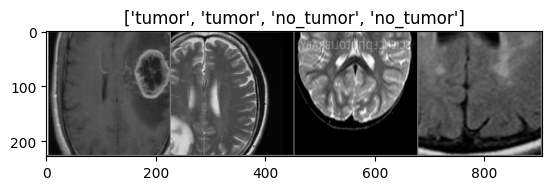

In [ ]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 40.1MB/s]


Epoch 0/14
----------
train Loss: 0.7881 Acc: 0.5213 Inference time: 1m 35s
val Loss: 0.7964 Acc: 0.6308 Inference time: 0m 54s
Epoch 1/14
----------
train Loss: 0.5984 Acc: 0.6968 Inference time: 0m 49s
val Loss: 0.3776 Acc: 0.8615 Inference time: 0m 14s
Epoch 2/14
----------
train Loss: 0.6271 Acc: 0.6809 Inference time: 0m 48s
val Loss: 0.3163 Acc: 0.9077 Inference time: 0m 15s
Epoch 3/14
----------
train Loss: 0.6568 Acc: 0.6383 Inference time: 0m 50s
val Loss: 0.3210 Acc: 0.8923 Inference time: 0m 15s
Epoch 4/14
----------
train Loss: 0.5703 Acc: 0.7606 Inference time: 0m 48s
val Loss: 0.3484 Acc: 0.8615 Inference time: 0m 13s
Epoch 5/14
----------
train Loss: 0.5431 Acc: 0.7340 Inference time: 0m 49s
val Loss: 0.3801 Acc: 0.8308 Inference time: 0m 15s
Epoch 6/14
----------
train Loss: 0.4545 Acc: 0.7713 Inference time: 0m 49s
val Loss: 0.3032 Acc: 0.8769 Inference time: 0m 13s
Epoch 7/14
----------
train Loss: 0.4281 Acc: 0.8245 Inference time: 0m 48s
val Loss: 0.2479 Acc: 0.9231

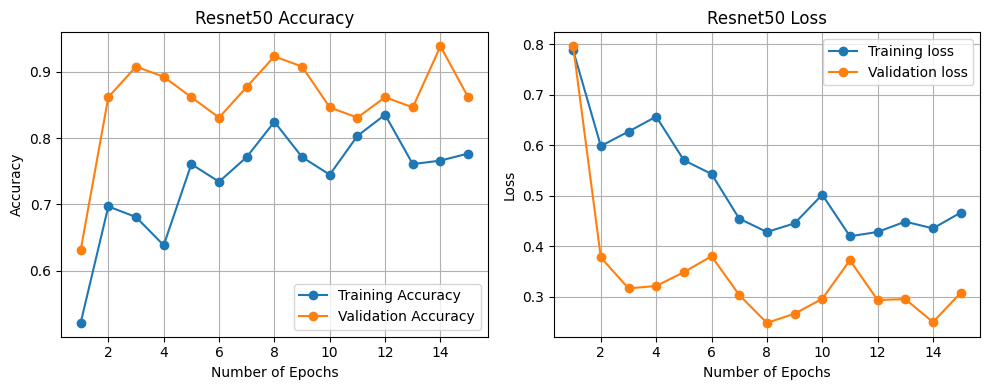

17.0


In [ ]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv, resnet_time = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, "Resnet50", num_epochs=15)
print(resnet_time)

### VGG-16

In [ ]:
# Loading in data.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
image_datasets =  {x: datasets.ImageFolder(os.path.join(PATH_TO_DATASET, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/14
----------
train Loss: 0.7184 Acc: 0.6223 Inference time: 6m 34s
val Loss: 0.5001 Acc: 0.7385 Inference time: 0m 39s
Epoch 1/14
----------
train Loss: 0.5817 Acc: 0.6809 Inference time: 6m 38s
val Loss: 0.4519 Acc: 0.8615 Inference time: 0m 42s
Epoch 2/14
----------
train Loss: 0.5824 Acc: 0.7394 Inference time: 6m 32s
val Loss: 0.6755 Acc: 0.4923 Inference time: 0m 40s
Epoch 3/14
----------
train Loss: 0.6260 Acc: 0.7181 Inference time: 6m 38s
val Loss: 0.5456 Acc: 0.6769 Inference time: 0m 40s
Epoch 4/14
----------
train Loss: 0.5649 Acc: 0.7394 Inference time: 6m 31s
val Loss: 0.5027 Acc: 0.8462 Inference time: 0m 39s
Epoch 5/14
----------
train Loss: 0.4480 Acc: 0.8404 Inference time: 6m 34s
val Loss: 0.2458 Acc: 0.9231 Inference time: 0m 39s
Epoch 6/14
----------
train Loss: 0.4007 Acc: 0.8617 Inference time: 6m 30s
val Loss: 0.2555 Acc: 0.9077 Inference time: 0m 41s
Epoch 7/14
----------
train Loss: 0.2718 Acc: 0.8830 Inference time: 6m 31s
val Loss: 0.2197 Acc: 0.9077

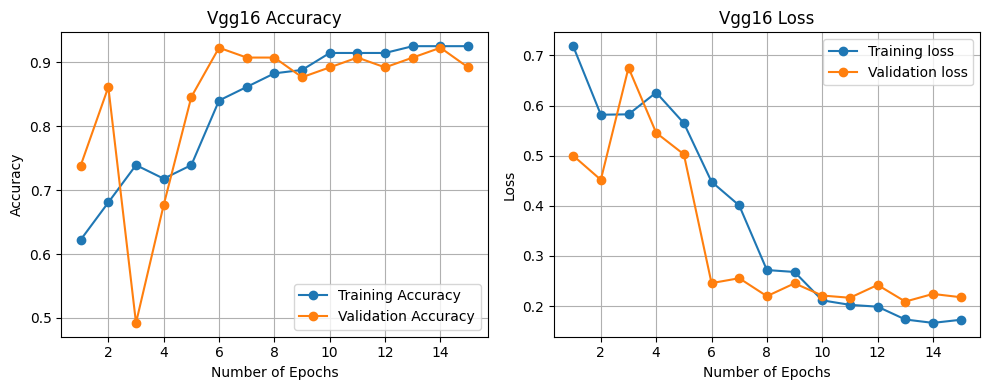

In [ ]:
model_vgg16 = torchvision.models.vgg16(pretrained=True)
for param in model_vgg16.classifier[6].parameters():
    param.requires_grad = False

num_classes = 2
in_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(in_features, num_classes)
criterion = nn.CrossEntropyLoss()

model_vgg16 = model_vgg16.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg16, step_size=7, gamma=0.1)

model_vgg16, vgg_time = train_model(model_vgg16, criterion, optimizer_vgg16,
                         exp_lr_scheduler, "Vgg16", num_epochs=15)

### Inception-V3

In [ ]:
# Loading in data.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((299)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((299)),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
image_datasets =  {x: datasets.ImageFolder(os.path.join(PATH_TO_DATASET, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/14
----------
train Loss: 0.7311 Acc: 0.5532 Inference time: 1m 11s
val Loss: 0.6224 Acc: 0.6308 Inference time: 0m 24s
Epoch 1/14
----------
train Loss: 0.6337 Acc: 0.6755 Inference time: 1m 9s
val Loss: 0.5361 Acc: 0.8769 Inference time: 0m 21s
Epoch 2/14
----------
train Loss: 0.6467 Acc: 0.6383 Inference time: 1m 9s
val Loss: 0.6752 Acc: 0.4923 Inference time: 0m 22s
Epoch 3/14
----------
train Loss: 0.6469 Acc: 0.6223 Inference time: 1m 13s
val Loss: 0.4433 Acc: 0.8000 Inference time: 0m 24s
Epoch 4/14
----------
train Loss: 0.7313 Acc: 0.6223 Inference time: 1m 9s
val Loss: 0.4836 Acc: 0.6923 Inference time: 0m 21s
Epoch 5/14
----------
train Loss: 0.6518 Acc: 0.6702 Inference time: 1m 9s
val Loss: 0.3997 Acc: 0.8923 Inference time: 0m 23s
Epoch 6/14
----------
train Loss: 0.5544 Acc: 0.7181 Inference time: 1m 12s
val Loss: 0.4263 Acc: 0.8308 Inference time: 0m 21s
Epoch 7/14
----------
train Loss: 0.5869 Acc: 0.6702 Inference time: 1m 9s
val Loss: 0.3736 Acc: 0.9231 Infe

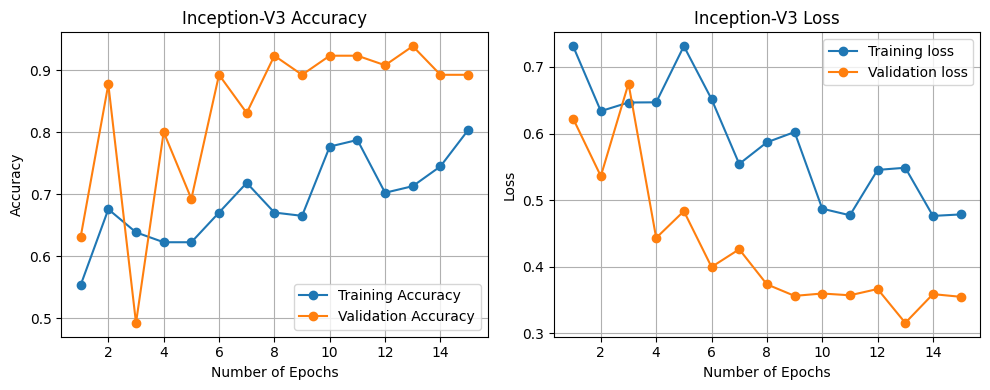

In [ ]:
model_incep = torchvision.models.inception_v3(pretrained=True)
for param in model_incep.parameters():
    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_classes = 2
num_ftrs = model_incep.fc.in_features
model_incep.fc = nn.Linear(num_ftrs, num_classes)


model_incep = model_incep.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_incep = optim.SGD(model_incep.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_incep, step_size=7, gamma=0.1)

model_incep, inception_time = train_model(model_incep, criterion, optimizer_incep,
                         exp_lr_scheduler, "Inception-V3", num_epochs=15)

### YOLOV8

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Loading the model
model = YOLO('yolov8n-cls.pt') # load a pretrained model

# Training the model with custom dataset.
# YOLO automatically replaces the last connected classfication layer to
# a layer that contains our 2 output classes
model.train(data=PATH_TO_DATASET, epochs=15, batch=4)

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/drive/MyDrive/cis4780_final/mri_dataset, epochs=15, patience=50, batch=4, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

train: Scanning /content/drive/MyDrive/cis4780_final/mri_dataset/train... 188 images, 0 corrupt: 100%|██████████| 188/188 [00:00<?, ?it/s]

albumentations: RandomResizedCrop(p=1.0, height=224, width=224, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1), HorizontalFlip(p=0.5), ColorJitter(p=0.5, brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.30000000000000004, 1.7], hue=[-0.015, 0.015]), Normalize(p=1.0, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0), ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)



val: Scanning /content/drive/MyDrive/cis4780_final/mri_dataset/val... 65 images, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train3
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]

                   all      0.692          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]

                   all      0.815          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.89it/s]

                   all      0.815          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


                   all        0.8          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s]

                   all      0.815          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  4.74it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  4.65it/s]

                   all      0.908          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]

                   all      0.892          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.57it/s]

                   all      0.892          1



      Epoch    GPU_mem       loss  Instances       Size


      10/15         0G     0.1572          4        224: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.60it/s]

                   all      0.908          1



      Epoch    GPU_mem       loss  Instances       Size


      11/15         0G     0.2344          4        224: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  4.77it/s]

                   all      0.908          1



      Epoch    GPU_mem       loss  Instances       Size


      12/15         0G     0.1376          4        224: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  4.72it/s]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


      13/15         0G     0.2072          4        224: 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]

                   all      0.908          1

      Epoch    GPU_mem       loss  Instances       Size



      14/15         0G     0.2068          4        224: 100%|██████████| 47/47 [00:13<00:00,  3.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s]

                   all      0.892          1



      Epoch    GPU_mem       loss  Instances       Size


      15/15         0G     0.1775          4        224: 100%|██████████| 47/47 [00:13<00:00,  3.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  6.55it/s]


                   all      0.908          1

15 epochs completed in 0.059 hours.
Optimizer stripped from runs/classify/train3/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train3/weights/best.pt, 3.0MB

Validating runs/classify/train3/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/drive/MyDrive/cis4780_final/mri_dataset/train... found 188 images in 2 classes ✅ 
val: /content/drive/MyDrive/cis4780_final/mri_dataset/val... found 65 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


                   all      0.938          1
Speed: 0.0ms preprocess, 12.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train3
Results saved to runs/classify/train3


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d5cb0c73d60>
curves: []
curves_results: []
fitness: 0.9692307710647583
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9384615421295166, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9692307710647583}
save_dir: PosixPath('runs/classify/train3')
speed: {'preprocess': 0.003246160653921274, 'inference': 12.875010417057917, 'loss': 0.0003447899451622596, 'postprocess': 0.00035579387958233175}
task: 'classify'
top1: 0.9384615421295166
top5: 1.0

In [ ]:
# DO NOT DELETE
# ONLY USED WHEN THE MODEL IS TRAINED again
#  Will have to change the source path to get results from each new run
!rm -rf '/content/drive/MyDrive/cis4780_final/yolo-latest-run/'
!scp -r '/content/runs/classify' '/content/drive/MyDrive/cis4780_final/yolo-latest-run'

### Processing Time

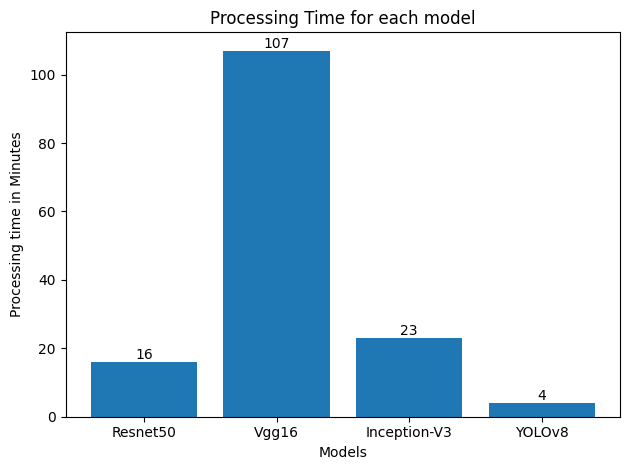

In [ ]:
# dataset
timing = [16, 107, 23, 4]
Models = ['Resnet50', 'Vgg16', 'Inception-V3', 'YOLOv8']
positions = range(len(timing))

# plot bar graph
bars = plt.bar(Models, timing)
# plt.barh

# replace axis label
plt.xticks(positions, Models)

plt.title('Processing Time for each model')

plt.xlabel('Models')
plt.ylabel('Processing time in Minutes')

plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.show()

### Colab testing

no_tumor_10.jpg  no_tumor_24.jpg  no_tumor_38.jpg  no_tumor_51.jpg  no_tumor_65.jpg
no_tumor_11.jpg  no_tumor_25.jpg  no_tumor_39.jpg  no_tumor_52.jpg  no_tumor_66.jpg
no_tumor_12.jpg  no_tumor_26.jpg  no_tumor_3.jpg   no_tumor_53.jpg  no_tumor_67.jpg
no_tumor_13.jpg  no_tumor_27.jpg  no_tumor_40.jpg  no_tumor_54.jpg  no_tumor_68.jpg
no_tumor_14.jpg  no_tumor_28.jpg  no_tumor_41.jpg  no_tumor_55.jpg  no_tumor_69.jpg
no_tumor_15.jpg  no_tumor_29.jpg  no_tumor_42.jpg  no_tumor_56.jpg  no_tumor_6.jpg
no_tumor_16.jpg  no_tumor_2.jpg   no_tumor_43.jpg  no_tumor_57.jpg  no_tumor_70.jpg
no_tumor_17.jpg  no_tumor_30.jpg  no_tumor_44.jpg  no_tumor_58.jpg  no_tumor_71.jpg
no_tumor_18.jpg  no_tumor_31.jpg  no_tumor_45.jpg  no_tumor_59.jpg  no_tumor_72.jpg
no_tumor_19.jpg  no_tumor_32.jpg  no_tumor_46.jpg  no_tumor_5.jpg   no_tumor_73.jpg
no_tumor_1.jpg   no_tumor_33.jpg  no_tumor_47.jpg  no_tumor_60.jpg  no_tumor_74.jpg
no_tumor_20.jpg  no_tumor_34.jpg  no_tumor_48.jpg  no_tumor_61.jpg  no_tumor_

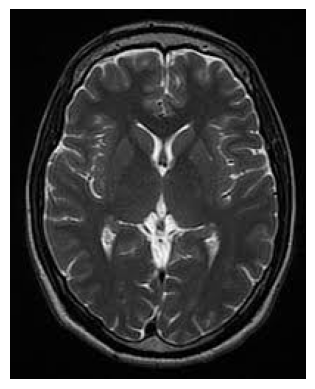

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = '/content/drive/MyDrive/cis4780_final/mri_dataset/train/no_tumor/no_tumor_10.jpg'
%ls {'/content/drive/MyDrive/cis4780_final/mri_dataset/train/no_tumor/'}
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

except Exception as e:
    print(f"Error: {e}")